In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import random
from deap import base, creator, tools
from deap.benchmarks.tools import hypervolume
import multiprocessing
multiprocessing.set_start_method('spawn', True)
from concurrent.futures import ProcessPoolExecutor
from functions import *
import time

#Setting GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = my_CNN2().to(device)
print("Model device:", next(model.parameters()).device)

#load trained model
model.load_state_dict(torch.load('new_CNN_notebook.pth'))

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# divide dataset into subsets
batch_size = 256
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

subset = torch.utils.data.Subset(trainset, range(0, 40000))
trainloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_set = torch.utils.data.Subset(trainset, range(40000, 50000))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)

partition_size = 5000
num_partitions = int(len(subset) / partition_size)
small_loaders = SmallLoaders(subset, partition_size, batch_size)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = trainset.classes

#load surrogate model
Chrom_length = model.fc2.weight.size()[0] * model.fc2.weight.size()[1] + model.fc2.bias.size()[0]
sur_model = Surrogate(input_size=Chrom_length).to(device)
sur_model.load_state_dict(torch.load('sur10k_state_dict.pth'))

Model device: cuda:0
Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

In [2]:
# set up experimental parameters
max_processes = 8
popSize = 80  # has to be a multiple of 4
NGEN = 100
nBits = 30
flipProb = 1 / (Chrom_length / nBits)
w1 = -1.0
w2 = -1.5
cxpb = 0.6
patience = 5

creator.create("FitnessMin", base.Fitness, weights=(w1, w2))  # Minimize both objectives
creator.create("Individual", list, fitness=creator.FitnessMin)

# create tools
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, nBits*(Chrom_length))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", calcFitness, trainloader=trainloader, model=model, nBits=nBits, Chrom_length=Chrom_length)
toolbox.register("validate", calcFitness, trainloader=val_loader, model=model, nBits=nBits, Chrom_length=Chrom_length)
toolbox.register("small_evaluation", calcFitness, trainloader=small_loaders[random.randint(0,num_partitions-1)], model=model, nBits=nBits, Chrom_length=Chrom_length)
toolbox.register("sur_eval", SurrogateEval, model=sur_model, nBits=nBits, Chrom_length=Chrom_length)

In [3]:
tic = time.time()
model.fc2.reset_parameters()

popa = toolbox.population(n=popSize)
pop=[]
# generate a population where each individual is a list
# of weights encoded in nBits bit chromosomes
for ind in popa:
    sep=separatevariables(ind, nBits, Chrom_length)
    weightlist=[]
    for weight in sep:
        weightlist+=real2chrom(weight, nBits)
    pop.append(creator.Individual(weightlist))

#already evaluate will contain indiviuals that do not need to be evaluated twice
already_evaluated = []

# Evaluate invalid population
invalid_ind = [ind for ind in pop if not ind.fitness.valid]
print("Evaluating invalid population (%i) ..." % len(invalid_ind))

eval_time = time.time()
with ProcessPoolExecutor(max_processes) as executor:
    fitnesses = list(executor.map(toolbox.small_evaluation, invalid_ind))
print("  Eval time: ", time.time() - eval_time, " seconds")

for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit
    already_evaluated.append(ind)

best_loss = []
avg_loss = []
val_loss = []

early_stopping = EarlyStopping(patience=patience)
less_surrogate = EarlyStopping(patience=patience)
freq = 5

# begin evolution
g = 0
while g < NGEN:
    g += 1
    toolbox.register("small_evaluation", calcFitness, trainloader=small_loaders[random.randint(0,num_partitions-1)], model=model, nBits=nBits, Chrom_length=Chrom_length)
    print("-- Generation %i --" % g)

    if g > 1:
        # sort pop in pareto fronts
        pareto_fronts = tools.sortNondominated(pop, popSize)

        for ind in pareto_fronts[0]:
            if ind not in already_evaluated:
                del ind.fitness.values

        invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    
        # evaluate 1st front with real function
        print("Evaluating new pre-selected 1st front inds (", len(invalid_ind), ") with real func...")
        starting_time2 = time.time()
        with ProcessPoolExecutor(max_processes) as executor:
            fitnesses = list(executor.map(toolbox.evaluate, invalid_ind))
        print("Eval time: ", time.time() - starting_time2, " seconds")
    
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            already_evaluated.append(ind)

    # assigning crowding distance
    pop = toolbox.select(pop, len(pop))

    # mate selection and reproduction
    offspring = tools.selTournamentDCD(pop, len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]

    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(ind1, ind2) 
        toolbox.mutate(ind1)
        toolbox.mutate(ind2)
        del ind1.fitness.values, ind2.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]

    # every freq number of generations the real function evaluates the offspring instead of the surrogate
    if g % freq == 0:
        print("Evaluating offspring using real func...")  
    else:
        print("Evaluating offspring using surrogate model...")
    starting_time = time.time()
    
    with ProcessPoolExecutor(max_processes) as executor:
        if g % freq != 0:
            fitnesses = list(executor.map(toolbox.sur_eval, invalid_ind))
        else:
            fitnesses = list(executor.map(toolbox.small_evaluation, invalid_ind))
    print("  Eval time: ", time.time() - starting_time, " seconds")
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # select next population
    pop = toolbox.select(pop + offspring, popSize)

    # graph data
    pop_losses = []
    for ind in pop:
        pop_losses.append(ind.fitness.values[0])
    best_loss.append(min(pop_losses))
    avg_loss.append(sum(pop_losses)/popSize)

    print("  Best loss: ", best_loss[g-1], "Average loss: ", avg_loss[g-1])

    print("Validating...")
    best_ind = tools.selBest(pop, 1)[0]
    validation_data = toolbox.validate(best_ind)
    val_loss.append(validation_data[0])
    print("  Validation loss: ", validation_data[0])

    # validation loss is used to determine if the usage of the surrogate model must decrease
    less_surrogate(validation_data[0])
    if less_surrogate.early_stop:
        freq = 2
        early_stopping(validation_data[0])
    # validation loss is used to determine if the stop function ends the evolution
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# final eval
for ind in pop:
    if ind not in already_evaluated:
        del ind.fitness.values

invalid_ind = [ind for ind in pop if not ind.fitness.valid]

print("Final full evaluation of population...")
starting_time2 = time.time()
with ProcessPoolExecutor(max_processes) as executor:
    fitnesses = list(executor.map(toolbox.validate, invalid_ind))
print("  Eval time: ", time.time() - starting_time2, " seconds")

for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

best_ind = tools.selBest(pop, 1)[0]

# best solution found, model upadted accoringly
weights_biases=separatevariables(best_ind, nBits, Chrom_length)

weights = weights_biases[:1280]
weights = np.asarray(weights, dtype=np.float32)
new_weights = torch.from_numpy(weights.reshape(model.fc2.weight.size()[0], model.fc2.weight.size()[1])).to(device)
model.fc2.weight = nn.Parameter(new_weights)

biases = weights_biases[1280:]
biases = np.asarray(biases, dtype=np.float32)
new_biases = torch.from_numpy(biases).to('cuda')
model.fc2.bias = torch.nn.Parameter(new_biases)

toc = time.time()
print("Total time elapsed: ", (toc-tic)/60, " minutes")

Evaluating invalid population (8) ...
  Eval time:  23.316410303115845  seconds
-- Generation 1 --
Evaluating offspring using surrogate model...
  Eval time:  3.5874061584472656  seconds
  Best loss:  129.91696815490724 Average loss:  146.95381531715392
Validating...
  Validation loss:  129.20358600616456
-- Generation 2 --
Evaluating new pre-selected 1st front inds ( 2 ) with real func...
Eval time:  12.863760232925415  seconds
Evaluating offspring using surrogate model...
  Eval time:  3.1501009464263916  seconds
  Best loss:  129.1152801513672 Average loss:  147.465394174673
Validating...
  Validation loss:  129.42016105651857
Final full evaluation of population...
  Eval time:  15.270928144454956  seconds
Total time elapsed:  1.2514797449111938  minutes



Final population hypervolume is 213465.167634


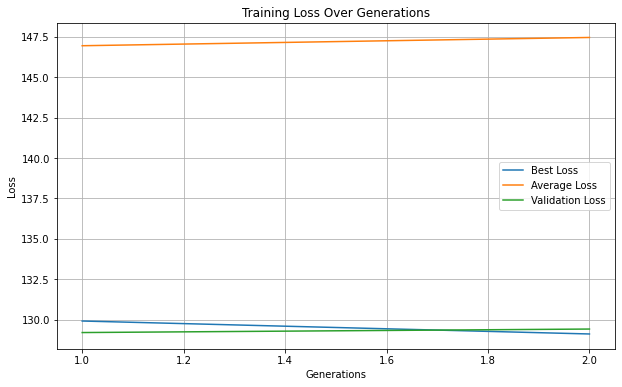

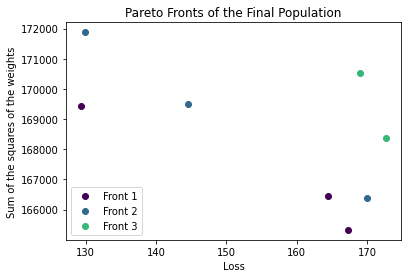

Accuracy of the network on the 10 000 test images: 23.080000 %
Accuracy for: airplane is 0.0 %
Accuracy for: automobile is 19.9 %
Accuracy for: bird  is 3.9 %
Accuracy for: cat   is 0.2 %
Accuracy for: deer  is 0.0 %
Accuracy for: dog   is 75.5 %
Accuracy for: frog  is 54.3 %
Accuracy for: horse is 33.3 %
Accuracy for: ship  is 42.2 %
Accuracy for: truck is 1.5 %


23.08

In [4]:
# display hyper-volume
print("\nFinal population hypervolume is %f" % hypervolume(pop))

# display loss over generations
plt.figure(figsize=(10, 6))
mylist = []
for i in range(0,g):
    mylist.append(i+1)
plt.plot(mylist, best_loss, label='Best Loss')
plt.plot(mylist, avg_loss, label='Average Loss')
plt.plot(mylist, val_loss, label='Validation Loss')
plt.xlabel('Generations')
plt.ylabel('Loss')
plt.title('Training Loss Over Generations')
plt.legend()
plt.grid(True)
plt.show()

# display Pareto fronts of the final pop.
pareto_fronts = tools.sortNondominated(pop, popSize)

for i, front in enumerate(pareto_fronts):
    color = plt.cm.viridis(i / len(pareto_fronts))
    for ind in front: 
        x = ind.fitness.values[0]
        y = ind.fitness.values[1]
        label = f'Front {i + 1}'
        plt.scatter(x, y, label=label, color=color)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.xlabel('Loss')
plt.ylabel('Sum of the squares of the weights')
plt.title('Pareto Fronts of the Final Population')
plt.legend(by_label.values(), by_label.keys())
plt.show()

# Calculate accuracy of the final model
Accuracy(model, testloader, classes)

In [5]:
# calculate accuracy of the solution with the best Omega (Gaussian regulariser) value
gaus_regs = []
for ind in pareto_fronts[0]:
    gaus_regs.append(ind.fitness.values[1])

best_gaus_reg = pareto_fronts[0][gaus_regs.index(min(gaus_regs))]
print(best_gaus_reg.fitness.values)

weights_biases=separatevariables(best_gaus_reg, nBits, Chrom_length)

weights = weights_biases[:1280]
weights = np.asarray(weights, dtype=np.float32)
new_weights = torch.from_numpy(weights.reshape(model.fc2.weight.size()[0], model.fc2.weight.size()[1])).to(device)
model.fc2.weight = nn.Parameter(new_weights)

biases = weights_biases[1280:]
biases = np.asarray(biases, dtype=np.float32)
new_biases = torch.from_numpy(biases).to('cuda')
model.fc2.bias = torch.nn.Parameter(new_biases)

Accuracy(model, testloader, classes)

(167.26195220947267, 165327.67731381315)
Accuracy of the network on the 10 000 test images: 13.490000 %
Accuracy for: airplane is 0.0 %
Accuracy for: automobile is 0.0 %
Accuracy for: bird  is 30.4 %
Accuracy for: cat   is 6.3 %
Accuracy for: deer  is 0.2 %
Accuracy for: dog   is 2.7 %
Accuracy for: frog  is 0.0 %
Accuracy for: horse is 84.3 %
Accuracy for: ship  is 1.0 %
Accuracy for: truck is 10.0 %


13.49

In [6]:
# Accuracy of all the solutions in the 1st Pareto front
acc_arr = []
for ind in pareto_fronts[0]:
    weights_biases=separatevariables(ind, nBits, Chrom_length)

    weights = weights_biases[:1280]
    weights = np.asarray(weights, dtype=np.float32)
    new_weights = torch.from_numpy(weights.reshape(model.fc2.weight.size()[0], model.fc2.weight.size()[1])).to(device)
    model.fc2.weight = nn.Parameter(new_weights)
    
    biases = weights_biases[1280:]
    biases = np.asarray(biases, dtype=np.float32)
    new_biases = torch.from_numpy(biases).to('cuda')
    model.fc2.bias = torch.nn.Parameter(new_biases)

    acc_arr.append(Accuracy(model, testloader, classes))

print(acc_arr)
average = 0.0
for i in range(len(acc_arr)):
    average += acc_arr[i]
average /= len(acc_arr)
print(average)

Accuracy of the network on the 10 000 test images: 13.490000 %
Accuracy for: airplane is 0.0 %
Accuracy for: automobile is 0.0 %
Accuracy for: bird  is 30.4 %
Accuracy for: cat   is 6.3 %
Accuracy for: deer  is 0.2 %
Accuracy for: dog   is 2.7 %
Accuracy for: frog  is 0.0 %
Accuracy for: horse is 84.3 %
Accuracy for: ship  is 1.0 %
Accuracy for: truck is 10.0 %
Accuracy of the network on the 10 000 test images: 23.080000 %
Accuracy for: airplane is 0.0 %
Accuracy for: automobile is 19.9 %
Accuracy for: bird  is 3.9 %
Accuracy for: cat   is 0.2 %
Accuracy for: deer  is 0.0 %
Accuracy for: dog   is 75.5 %
Accuracy for: frog  is 54.3 %
Accuracy for: horse is 33.3 %
Accuracy for: ship  is 42.2 %
Accuracy for: truck is 1.5 %
Accuracy of the network on the 10 000 test images: 9.260000 %
Accuracy for: airplane is 1.2 %
Accuracy for: automobile is 68.6 %
Accuracy for: bird  is 0.0 %
Accuracy for: cat   is 0.5 %
Accuracy for: deer  is 15.0 %
Accuracy for: dog   is 5.1 %
Accuracy for: frog  is 0

In [7]:
# Update the model with the best solution
best_ind = tools.selBest(pop, 1)[0]


weights_biases=separatevariables(best_ind, nBits, Chrom_length)

weights = weights_biases[:1280]
weights = np.asarray(weights, dtype=np.float32)
new_weights = torch.from_numpy(weights.reshape(model.fc2.weight.size()[0], model.fc2.weight.size()[1])).to(device)
model.fc2.weight = nn.Parameter(new_weights)

biases = weights_biases[1280:]
biases = np.asarray(biases, dtype=np.float32)
new_biases = torch.from_numpy(biases).to('cuda')
model.fc2.bias = torch.nn.Parameter(new_biases)